# Amortized Inference for a NLME Model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pypesto import visualize, optimize, profile, engine

from inference.helper_functions import (create_mixed_effect_model_param_names,
                                        analyse_correlation_in_posterior,
                                        create_fixed_params)
from inference.inference_functions import run_population_optimization
from inference.nlme_objective import get_covariance
from inference.ploting_routines import (plot_real_vs_synthetic,
                                        plot_real_and_estimated,
                                        plot_estimated_distributions,
                                        plot_normal_distributions,
                                        visualize_pesto_result)

/Users/jonas.arruda/miniconda/envs/amortizedNLME/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# specify which model to use
model_name = ['fröhlich-simple', 'fröhlich-detailed', 'fröhlich-sde', 
              'pharmacokinetic_model', 
              'clairon_small_model'][-2]

# Load individual model

  Activating project at `~/PyCharm Projects/Amortized-NLME/models/SimulatorPharma`
[ Info: Precompiling SciMLBasePythonCallExt [2797fd30-2078-5027-980c-4c2c8a19c528]
ERROR: LoadError: ArgumentError: Package PythonCall [6099a3de-0909-46bc-b1f4-468b9a2dfc0d] is required but does not seem to be installed:
 - Run `Pkg.instantiate()` to install all recorded dependencies.

Stacktrace:
 [1] _require(pkg::Base.PkgId, env::String)
   @ Base ./loading.jl:1774
 [2] _require_prelocked(uuidkey::Base.PkgId, env::String)
   @ Base ./loading.jl:1660
 [3] macro expansion
   @ ./loading.jl:1648 [inlined]
 [4] macro expansion
   @ ./lock.jl:267 [inlined]
 [5] require(into::Module, mod::Symbol)
   @ Base ./loading.jl:1611
 [6] include
   @ ./Base.jl:457 [inlined]
 [7] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Base.PkgId, UInt128}}, source::Nothing)
   @ Base ./loading.jl:2049
 [

using a split network with 2 splits, in each 2 layers of MultiConv1D, a bidirectional LSTM with 256 units and a dense layer with output dimension 22 as summary network
using a 8-layer cINN as inference network with 2 layers of design spline
prior mean: [-5.   6.5  2.5  2.5  6.5  0.   6.5 -3.  -1.  -1.   0. ]
prior covariance diagonal: [4.5 1.  1.  1.  1.  1.  1.  4.5 2.  2.  1. ]
Using the PharmacokineticModel


INFO:root:Performing 2 pilot runs with the PharmacokineticModel model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 11)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 26, 4)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Loaded loss history from ../networks/amortizer-pharma-split-sequence-summary-Bi-LSTM-8layers-2coupling-spline-500epochs/history_584.pkl.
INFO:root:Networks loaded from ../networks/amortizer-pharma-split-sequence-summary-Bi-LSTM-8layers-2coupling-spline-500epochs/ckpt-584
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Model: "amortized_posterior"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Inverti  multiple                 924216    
 bleNetwork)                                                     
                                                                 
 split_network (SplitNetwork  multiple                 1221804   
 )                                                               
                                                                 
Total params: 2,146,020
Trainable params: 2,145,844
Non-trainable params: 176
_________________________________________________________________
None


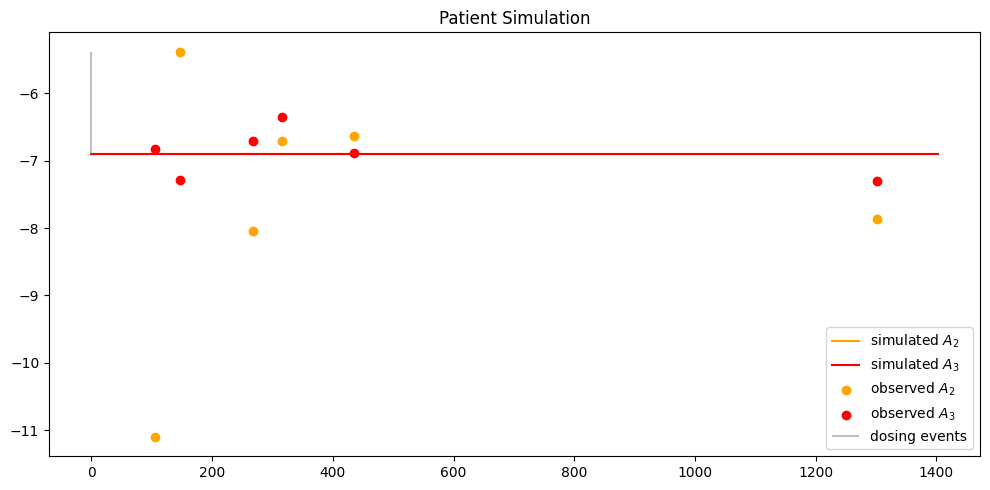

In [3]:
if model_name == 'fröhlich-simple':
    from models.froehlich_model_simple import FroehlichModelSimple
    individual_model = FroehlichModelSimple(load_best=True)
elif model_name == 'fröhlich-detailed':
    from models.froehlich_model_detailed import FroehlichModelDetailed
    individual_model = FroehlichModelDetailed(load_best=True)
elif model_name == 'fröhlich-sde':
    from models.froehlich_model_sde import FroehlichModelSDE
    individual_model = FroehlichModelSDE(load_best=True)    
elif model_name == 'pharmacokinetic_model':
    from models.pharmacokinetic_model import PharmacokineticModel
    individual_model = PharmacokineticModel(load_best=True)    
elif model_name == 'clairon_small_model':
    from models.clairon_small_model import ClaironSmallModel
    prior_type = ['normal', 'uniform'][0]
    individual_model = ClaironSmallModel(load_best=True, prior_type=prior_type)
else:
    raise NotImplementedError('model not implemented')

# assemble simulator and prior
trainer = individual_model.build_trainer('../networks/' + individual_model.network_name)
individual_model.plot_example()

## Load Data

In [4]:
# define how many data points are used for optimization
n_data = 200
load_real_data = False
# load data
true_pop_parameters = None
results_to_compare = None
if 'Froehlich' in individual_model.name:
    obs_data = individual_model.load_data(n_data=n_data, synthetic=not load_real_data, 
                                          load_egfp=True, load_d2egfp=False)  # if both are loaded, a 2d-list is returned
    if not load_real_data:
        true_pop_parameters = individual_model.load_synthetic_parameter(n_data=n_data)
    
    # load SDE data for comparison
    #from models.froehlich_model_sde import FroehlichModelSDE
    #model_sde = FroehlichModelSDE(load_best=True)
    #obs_data = model_sde.load_data(n_data=n_data, synthetic=True)
    #true_pop_parameters_sde = model_sde.load_synthetic_parameter(n_data=n_data)
else:
    if load_real_data:
        obs_data = individual_model.load_data(n_data=n_data)
    else:
        obs_data, true_pop_parameters = individual_model.load_data(n_data=n_data, synthetic=True, return_synthetic_params=True)

print(len(obs_data), 'individuals')

200 individuals


# Estimating Population Parameters

Now we want to use the amortizer to generate samples such that we can minimize the negative log-likelihood of the data given the population parameters of the mixed effect model:
$$
    \beta^*,\Psi^* \approx 
    \underset{\beta,\Psi}{\arg\min} -\sum_i \log\left( \frac1M \sum_j^M \frac{p(\phi_j \mid \beta,\Psi)}{p(\phi_j)} \right).
$$

Remark: the objective value is not the likelihood value since the sum over $\log p(y_i)$ is missing.


$\beta$ is called ```theta_population``` in the code.


$\log \phi$ cell specific parameters, sampled from $\mathcal{N}(\beta,\Psi)$
$$
    p( \phi \mid \beta,\Psi) = (2\pi)^{-k/2}\vert \Psi\vert^{-1/2} \prod_{l=1}^k \phi_l^{-1} \exp \left(-\frac12 (\log \phi-\beta)^T \Psi^{-1}  (\log \phi-\beta) \right)
$$

Assumptions to start with: $\Psi$ is a diagonal matrix, need better parameterization for other types

$$
    \beta^*,\Psi^* \approx
    \underset{\beta,\Psi}{\arg\min} -\sum_i \left(\log \frac1M \sum_j^M \frac{p( \phi_j \mid \beta,\Psi)}{p( \phi_j)} \right) \\
     =  \underset{\beta,\Psi}{\arg\min} -\sum_i \left(\log\left(\vert \Psi\vert^{-1/2} \right) -\log M -
    \log\left(\vert \Sigma\vert^{-1/2}\right) +\log \sum_j^M \exp \left(-\frac12 (\log\phi_j-\beta)^T \Psi^{-1}  (\log\phi_j-\beta) + \frac12 (\log\phi_j-\mu)^T \Sigma^{-1}  (\log\phi_j-\mu) \right)\right)
$$

if the prior is $p( \phi) = (2\pi)^{-k/2}\vert \Sigma\vert^{-1/2} \prod_{l=1}^k \phi_l^{-1}\exp \left(-\frac12 (\log \phi-\mu)^T \Sigma^{-1}  (\log\phi-\mu) \right)$.


For purpose of optimization we also parametrize $\Psi$ by a log-transformation since diagonal entries must be positive.

## Define Objective Function

- you have to choose the covariance format (diag or cholesky)
- if you want to use covariates, you have to specify the covariate mapping to the parameters of the log-normal distribution
- a covariate mapping takes in parameter samples (n_indv, n_samples, n_params), covariates (n_indv, n_covariates) and parameter vector with parameters needed to map the covariates into the other parameter from the mixed effects model and returns transformed parameter samples (n_indv, n_samples, n_params)

In [5]:
cov_type = ['diag', 'cholesky'][0]
use_covariates = False

In [6]:
# build covariate mapping if needed
covariates_bounds = None
covariate_mapping = None
n_covariates_params = 0
covariates = None
covariates_names = []

if use_covariates and 'fröhlich' in model_name:
    # experiment specific gamma
    covariates_names = ['$factor-\gamma_{d2eGFP}$', '$factor-var-\gamma_{d2eGFP}$']
    n_covariates_params = len(covariates_names)
    covariates_bounds = np.array([[-5, 5], [-2, 2]])
elif use_covariates and 'clairon' in model_name:
    covariates_names = ['c_age', 'c_gender']
    n_covariates_params = len(covariates_names)
    covariates_bounds = np.array([[-1, 1], [-1, 1]])

In [7]:
if use_covariates and 'fröhlich' in model_name:
    index_gamma = [i for i, x in enumerate(individual_model.param_names) if 'gamma' in x][0]
    
    # obs_data consists of two groups, first group is eGFP, second group is d2eGFP
    if covariates is None:
        assert len(obs_data) == 2, 'you should load two groups of data'
        covariates = np.concatenate((np.zeros(len(obs_data[0])), np.ones(len(obs_data[1]))))[:, np.newaxis]
        obs_data = np.concatenate((obs_data[0], obs_data[1]))
    
    
    def multi_experiment_mapping(beta: np.ndarray,
                                 psi_inverse: np.ndarray,
                                 covariates: np.ndarray,
                                 covariate_params: np.ndarray):
        # add param_of_cov*covariates to parameter gamma
        # covariate_params[0] < 0 expected since lifetime of d2eGFP is lower than eGFP
        beta_transformed = np.repeat(beta[np.newaxis, :], covariates.shape[0], axis=0)
        psi_inverse_transformed = np.repeat(psi_inverse[np.newaxis, :, :], covariates.shape[0], axis=0)
        
        shit_beta = covariate_params[0] * covariates.flatten()  # flatten since only one covariate
        shift_var = covariate_params[1] * covariates.flatten()
        
        for s_id in range(covariates.shape[0]):
            # individual_param_i = gamma_{eGFP} + gamma_{d2eGFP} * c + random_effect_{eGFP}, c in {0,1}
            beta_transformed[s_id, index_gamma] += shit_beta[s_id]
            # variance needs to be constrained
            temp_var = 1. / psi_inverse_transformed[s_id, index_gamma, index_gamma] + shift_var[s_id]
            if temp_var  <= 0.001:
                temp_var = 0.001
            psi_inverse_transformed[s_id, index_gamma, index_gamma] = 1. / temp_var
        return beta_transformed, psi_inverse_transformed
    
    covariate_mapping = multi_experiment_mapping
    
    
elif use_covariates and 'clairon' in model_name:
    _, covariates = individual_model.load_data(n_data=n_data, load_covariates=True)
    
    # todo: this is still the old kind of mapping
    def additive_covariate_mapping(param_samples: np.ndarray, 
                                   covariates: np.ndarray, 
                                   covariate_params: np.ndarray, 
                                   threshold: float = 0.001):
        # add param_of_cov*covariates to parameters
        additive_cov = np.sum(covariate_params*covariates, axis=1)
        transformed_param_samples = np.exp(param_samples)
        
        for s_id in range(transformed_param_samples.shape[0]):
            # estimating exp(pop_mean), param_cov, variance of random_effect with 0 mean
            # exp(individual_param_i) = exp(pop_mean + random_effect) + param_cov * cov_i
            transformed_param_samples[s_id, :, :] -= additive_cov[s_id]  # cov on one parameter
        # if parameters are negative, set to threshold
        transformed_param_samples[transformed_param_samples < 0] = threshold
        param_samples_cov = np.log(transformed_param_samples)
        return param_samples_cov
    
    
    def multiplicative_covariate_mapping(param_samples: np.ndarray, 
                                         covariates: np.ndarray, 
                                         covariate_params: np.ndarray):
        # add param_of_cov*covariates to parameters
        additive_cov = np.sum(covariate_params*covariates, axis=1)
        
        for s_id in range(param_samples.shape[0]):
            # estimating exp(pop_mean), param_cov, variance of random_effect with 0 mean
            # individual_param_i = pop_mean + random_effect + param_cov * cov_i
            # since parameters are log-normal distributed, results in a multiplicative effect
            param_samples[s_id, :, :] -= additive_cov[s_id] 
        return param_samples
    
    covariate_mapping = [additive_covariate_mapping, multiplicative_covariate_mapping][0]

In [8]:
mixed_effect_params_names = create_mixed_effect_model_param_names(individual_model.param_names, 
                                                                  cov_type=cov_type,
                                                                  covariates_names=covariates_names)
print(mixed_effect_params_names)

['pop-$\\theta_1$', 'pop-$\\theta_2-\\eta_1$', 'pop-$\\theta_4-\\eta_3$', 'pop-$\\theta_5$', 'pop-$\\theta_6-\\eta_2$', 'pop-$\\theta_7$', 'pop-$\\theta_8$', 'pop-$\\theta_{10}$', 'pop-$\\theta_{12}$', 'pop-$\\theta_{13}$', 'pop-$\\eta_4$', 'var-$\\theta_1$', 'var-$\\theta_2-\\eta_1$', 'var-$\\theta_4-\\eta_3$', 'var-$\\theta_5$', 'var-$\\theta_6-\\eta_2$', 'var-$\\theta_7$', 'var-$\\theta_8$', 'var-$\\theta_{10}$', 'var-$\\theta_{12}$', 'var-$\\theta_{13}$', 'var-$\\eta_4$']


### Analyse correlations between parameters

Parameter pairs of high correlation in individual posterior: []


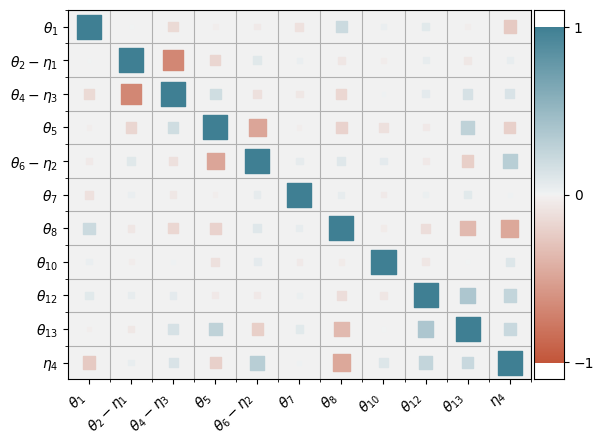

In [9]:
high_correlation_pairs = analyse_correlation_in_posterior(model=individual_model, 
                                                          mixed_effect_params_names=mixed_effect_params_names, 
                                                          obs_data=obs_data,
                                                          threshold_corr=0.5)
print('Parameter pairs of high correlation in individual posterior:', np.array(mixed_effect_params_names)[high_correlation_pairs])

## Fixed and Random Effects

Decide which parameters to fix
- a fixed effect is modeled as a random effect with variance 0 (all parameters follow a normal distribution)
- variance of error parameters in the individual model are usually supposed to be a fixed parameter in the population model
- correlations with these error parameters are usually fixed to 0


In [10]:
if 'Froehlich' in individual_model.name:
    # fix variance of error parameters and correlations with sigma if cholesky covariance is used
    fix_names = ['var-$\sigma$'] + [name for name in mixed_effect_params_names if '\sigma' in name and 'corr_' in name]
    fixed_values = [0] * len(fix_names)
elif 'Pharmacokinetic' in individual_model.name:
    fix_error_var = ['var-$\\theta_{12}$', 'var-$\\theta_{13}$']
    fix_error_var_val = [0] * len(fix_error_var)
    # fix variance of fixed parameters
    fixed_effects_var = ['var-$\\theta_1$', 'var-$\\theta_5$', 'var-$\\theta_7$', 'var-$\\theta_8$', 
                         'var-$\\theta_{10}$', 'var-$\\theta_{12}$', 'var-$\\theta_{13}$']
    fixed_effects_var_val = [0] * len(fixed_effects_var)
    # fix mean of random effect
    random_effect_mean = ['pop-$\eta_4$']
    random_effect_mean_val = [0]
    
    # put all fixed parameters together
    fix_names = fix_error_var + fixed_effects_var + random_effect_mean
    fixed_values = fix_error_var_val + fixed_effects_var_val + random_effect_mean_val
    
    # if correlations are used, only allow the same as in the original model
    # hence correlations with the error parameter are fixed as well
    if cov_type == 'cholesky':
        non_fix_corr = ['corr_$\\theta_2-\\eta_1$_$\\theta_6-\\eta_2$', 
                        'corr_$\\theta_4-\\eta_3$_$\\theta_6-\\eta_2$', 
                        'corr_$\\theta_4-\\eta_3$_$\\eta_4$']
        fixed_corr = [x for x in mixed_effect_params_names if 'corr_' in x and x not in non_fix_corr]
        fix_names += fixed_corr
        fixed_values += [0] * len(fixed_corr)
    
elif 'Clairon' in individual_model.name:
    fix_names = ['var-error_constant', 'var-error_prop'] + [name for name in mixed_effect_params_names if 
                                                            'error' in name and 'corr_' in name]
    fixed_values = [0] * len(fix_names)
else:
    raise NotImplementedError('model not yet implemented')
    
# "fix" is here in the context of parameters which are not optimized
fixed_indices, fixed_values = create_fixed_params(fix_names=fix_names, 
                                                  fixed_values=fixed_values,
                                                  params_list=mixed_effect_params_names, 
                                                  fix_low_correlation=True,  # only applies to cholesky covariance
                                                  high_correlation_pairs=high_correlation_pairs)
print(mixed_effect_params_names)
# note: inf values in fixed_values will be set to upper or lower bound respectively

['pop-$\\theta_1$', 'pop-$\\theta_2-\\eta_1$', 'pop-$\\theta_4-\\eta_3$', 'pop-$\\theta_5$', 'pop-$\\theta_6-\\eta_2$', 'pop-$\\theta_7$', 'pop-$\\theta_8$', 'pop-$\\theta_{10}$', 'pop-$\\theta_{12}$', 'pop-$\\theta_{13}$', 'pop-$\\eta_4$', 'var-$\\theta_1$', 'var-$\\theta_2-\\eta_1$', 'var-$\\theta_4-\\eta_3$', 'var-$\\theta_5$', 'var-$\\theta_6-\\eta_2$', 'var-$\\theta_7$', 'var-$\\theta_8$', 'var-$\\theta_{10}$', 'var-$\\theta_{12}$', 'var-$\\theta_{13}$', 'var-$\\eta_4$']


In [11]:
# fix covariates parameters
#fixed_indices = np.append(fixed_indices, 12)
#fixed_values = np.append(fixed_values, -2)

# Run Population Optimization

In [ ]:
%%time
result_optimization, obj_fun_amortized = run_population_optimization(
    individual_model=individual_model,
    data=obs_data,
    param_names=mixed_effect_params_names,
    cov_type=cov_type,
    n_multi_starts=10,
    n_samples_opt=100,
    covariates_bounds=covariates_bounds,
    covariates=covariates,
    n_covariates_params=n_covariates_params,
    covariate_mapping=covariate_mapping,
    x_fixed_indices=fixed_indices,
    x_fixed_vals=fixed_values,
    file_name=None, # f'../output/{model_name}-{cov_type}-n_data_{n_data}.hdf5',
    verbose=True,
    trace_record=True,
    pesto_multi_processes=10,
    result=None #result_optimization
    )

result_optimization.optimize_result.summary()

Multi-start optimization:   0%|          | 0/1 [00:00<?, ?it/s]

                                  free    lb_full   ub_full
pop-$\theta_1$                    True -11.363961  1.363961
pop-$\theta_2-\eta_1$             True   3.500000  9.500000
pop-$\theta_4-\eta_3$             True  -0.500000  5.500000
pop-$\theta_5$                    True  -0.500000  5.500000
pop-$\theta_6-\eta_2$             True   3.500000  9.500000
pop-$\theta_7$                    True  -3.000000  3.000000
pop-$\theta_8$                    True   3.500000  9.500000
pop-$\theta_{10}$                 True  -9.363961  3.363961
pop-$\theta_{12}$                 True  -5.242641  3.242641
pop-$\theta_{13}$                 True  -5.242641  3.242641
pop-$\eta_4$                     False  -3.000000  3.000000
$-\log$ (var-$\theta_1$)         False  -6.610187  6.117736
$-\log$ (var-$\theta_2-\eta_1$)   True  -6.610187  6.117736
$-\log$ (var-$\theta_4-\eta_3$)   True  -6.610187  6.117736
$-\log$ (var-$\theta_5$)         False  -6.610187  6.117736
$-\log$ (var-$\theta_6-\eta_2$)   True  


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
visualize_pesto_result(result_optimization, use_batch_coloring=True, obj_fun_amortized=obj_fun_amortized)

In [ ]:
# show best result
results = result_optimization.optimize_result.x
estimated_beta = results[0][:individual_model.n_params]
estimated_var = np.exp(-results[0][individual_model.n_params:individual_model.n_params*2])
if n_covariates_params == 0:
    estimated_psi = get_covariance(results[0][individual_model.n_params:], 
                                   covariance_format=cov_type, param_dim=individual_model.n_params)
else:
    estimated_psi = get_covariance(results[0][individual_model.n_params:-n_covariates_params],
                                   covariance_format=cov_type, param_dim=individual_model.n_params)
    estimated_covariates_params = results[0][-n_covariates_params:]

display(pd.DataFrame(estimated_beta,
                     index=mixed_effect_params_names[:individual_model.n_params],
                     columns=['estimated population parameters']))
display(pd.DataFrame(estimated_var,
                     index=mixed_effect_params_names[individual_model.n_params:individual_model.n_params*2],
                     columns=['estimated population parameters']))
if cov_type == 'cholesky' or use_covariates:
    display(pd.DataFrame(results[0][individual_model.n_params*2:],
                         index=mixed_effect_params_names[individual_model.n_params*2:],
                         columns=['estimated population parameters']))
    
display(pd.DataFrame(np.var([r for r in results], axis=0),
                     index=mixed_effect_params_names,
                     columns=['variance of multi-start results']))

In [ ]:
plot_normal_distributions(estimated_beta, estimated_psi, 
                          title='Population Parameter Distribution',
                          lb=result_optimization.problem.lb,
                          ub=result_optimization.problem.ub,
                          param_names_plot=individual_model.log_param_names)

plot_normal_distributions(individual_model.prior_mean, individual_model.prior_cov, 
                          title='Prior Parameter Distribution with Individual Posterior Samples',
                          posterior_samples=obj_fun_amortized.param_samples,
                          lb=result_optimization.problem.lb,
                          ub=result_optimization.problem.ub,
                          param_names_plot=individual_model.log_param_names)

if true_pop_parameters is not None:
    if true_pop_parameters.ndim == 2:
        true_mean = np.mean(true_pop_parameters, axis=0)
        true_cov = np.diag(np.var(true_pop_parameters, axis=0))
    else:
        true_mean = true_pop_parameters[:individual_model.n_params]
        true_cov = np.diag(true_pop_parameters[individual_model.n_params:])
    true_cov[true_cov < 0.001] = 0.001  # smaller cannot be estimated
    
    plot_normal_distributions(true_mean, 
                              true_cov, 
                              title='True Population Parameter Distribution',
                              #posterior_samples=obj_fun_amortized.param_samples,
                              lb=result_optimization.problem.lb,
                              ub=result_optimization.problem.ub,
                              param_names_plot=individual_model.log_param_names)

In [ ]:
if 'fröhlich' in model_name:
    plot_real_vs_synthetic(estimated_mean=estimated_beta,
                           estimated_cov=estimated_psi,
                           data=obs_data[:n_data//2] if n_covariates_params > 0 else obs_data,
                           model_name=individual_model.name,
                           n_trajectories=n_data//2 if n_covariates_params > 0 else n_data,
                           simulator=individual_model.simulator,
                           #save_fig='dif_ode', #model_name+'_eGFP_dif' if load_real_data else model_name+'_synthetic_dif',
                           #estimation_function=np.median,
                           ylim=(-1.,1.),
                           seed=0)
    plot_real_and_estimated(estimated_mean=estimated_beta,
                           estimated_cov=estimated_psi,
                           data=obs_data[:n_data//2] if n_covariates_params > 0 else obs_data,
                           model_name=individual_model.name,
                           n_trajectories=n_data//2 if n_covariates_params > 0 else n_data,
                           simulator=individual_model.simulator,
                           #save_fig=model_name+'_eGFP_estimate' if load_real_data else model_name+'_synthetic_estimate',
                           seed=0)
    
    if n_covariates_params > 0:
        estimated_beta_d2, estimated_inv_psi_d2 = covariate_mapping(estimated_beta, 
                                                                    np.linalg.inv(estimated_psi), 
                                                                    covariates, 
                                                                    estimated_covariates_params)
        estimated_beta_d2 = estimated_beta_d2[-1]  # only second group, mean is the same for the whole group
        estimated_inv_psi_d2 = estimated_inv_psi_d2[-1]
        estimated_psi_d2 = np.linalg.inv(estimated_inv_psi_d2)
        
        plot_real_vs_synthetic(estimated_mean=estimated_beta_d2,
                           estimated_cov=estimated_psi_d2,
                           data=obs_data[n_data//2:],
                           model_name=individual_model.name,
                           n_trajectories=n_data//2,
                           simulator=individual_model.simulator,
                           ylim=(-1.,1.),
                           seed=0)
        plot_real_and_estimated(estimated_mean=estimated_beta_d2,
                               estimated_cov=estimated_psi_d2,
                               data=obs_data[n_data//2:],
                               model_name=individual_model.name,
                               n_trajectories=n_data//2,
                               simulator=individual_model.simulator,
                               seed=0)

In [ ]:
plot_parameter_estimates(results_transformed,
                         param_names_plot=full_param_names,
                         prior_mean=prior_mean,
                         prior_std=prior_std,
                         true_parameters=true_pop_parameters,
                         save_fig=False)

In [ ]:
plot_estimated_distributions(results_transformed[0],
                             param_names_plot=param_names,
                             prior_mean=prior_mean,
                             prior_std=prior_std,
                             true_parameters=true_pop_parameters,
                             save_fig=False)

In [ ]:
if results_to_compare is not None:
    compare_list = [results_transformed[0], results_to_compare[0]]
    plot_parameter_estimates(compare_list, param_names_plot=full_param_names,
                         prior_mean=model.prior_mean,
                         prior_std=model.prior_std,
                         true_parameters=true_pop_parameters,
                         run_names=['BayesFlow', 'Baseline'],
                         save_fig=False)

    print('Baseline Estimated Parameters')
    plot_parameter_estimates(results_to_compare, param_names_plot=full_param_names,
                         prior_mean=model.prior_mean,
                         prior_std=model.prior_std,
                         save_fig=False)

# Uncertainty Analysis

Uncertainty based on profiles -> more accurate

In [ ]:
profile_options = profile.ProfileOptions(
    min_step_size=0.0005, #0.001
    step_size_factor=1.1, #1.25
    delta_ratio_max=0.05, #0.1
    default_step_size=0.005, #0.01
    ratio_min=0.01, #0.145
)

result_optimization = profile.parameter_profile(
    problem=result_optimization.problem,
    result=result_optimization,
    optimizer=optimize.ScipyOptimizer(),
    engine=engine.MultiProcessEngine(10),
    #profile_index=np.array([0]),
    #result_index=0, # index from which optimization result profiling should be started
    #profile_options=profile_options,
    #filename=f'output/uncertainty/{model.name}_cells_{n_data}_samples_{50}.hd5',
    #overwrite=True
)

In [ ]:
import matplotlib

matplotlib.rcdefaults()  # for resetting to defaults
plt.rcParams.update({'font.size': 14,
                     #'text.usetex': True,
                     "font.family": "serif",
                     "font.serif": ["Computer Modern Roman"],
                     'axes.titlesize': 'small',
                     'axes.labelsize': 'small',
                     'xtick.labelsize': 'xx-small', # todo: change back to small
                     'ytick.labelsize': 'small',
                     'legend.fontsize': 'small',
                     #'figure.dpi': 600,
                     'figure.figsize': (16,12)}) #
colors = ['#1f78b4', '#a6cee3', '#b2df8a','#33a02c','#fb9a99']

In [ ]:
ax = visualize.profiles(result_optimization, size=(16,12))
#plt.savefig('plots/synthetic_profiles_small_stochastic_data.pdf', bbox_inches='tight', dpi=600, format='pdf')
plt.show()

In [ ]:
ax = visualize.profile_cis(result_optimization) #,
                                  #profile_indices=[0,1,2,3,4,5,6,7,8,9,10,11])
ax.set_title('Approximate Confidence Intervals \n Based on Profiles')
plt.tight_layout()
#plt.savefig('plots/synthetic_FIM_profiles_cis.png')
plt.show()

Uncertainty based on FIM

In [ ]:
result_optimization = profile.approximate_parameter_profile(
    problem=result_optimization.problem,
    result=result_optimization,
    #profile_index=np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    #result_index=0, # index from which optimization result profiling should be started
)

In [ ]:
visualize.profiles(result_optimization)
#plt.savefig('plots/synthetic_FIM_profiles.png')
plt.show()

In [ ]:
n_indv = obs_data.shape[0]
confidence_ratio = profile.chi2_quantile_to_ratio(alpha=0.95, df=n_indv-(model.n_params*2))

confidence_intervals = np.zeros((model.n_params*2, 2))

for param_idx in range(model.n_params*2):
    try:
        xs = result_optimization.profile_result.list[0][param_idx]['x_path'][param_idx]
        ratios = result_optimization.profile_result.list[0][0]['ratio_path']
        confidence_intervals[param_idx] = profile.calculate_approximate_ci(xs, ratios,
                                                                            confidence_ratio=confidence_ratio)
    except TypeError:
        print(f'for {full_param_names[param_idx]} confidence interval could not be estimated')

confidence_intervals